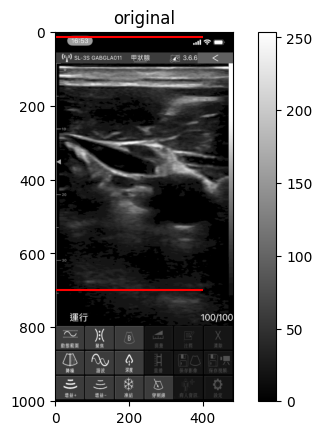

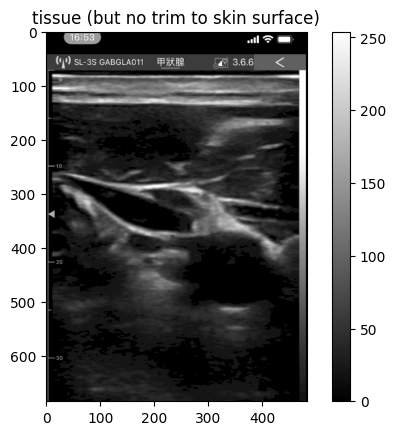

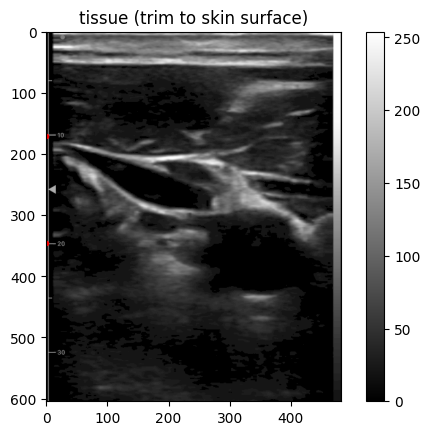

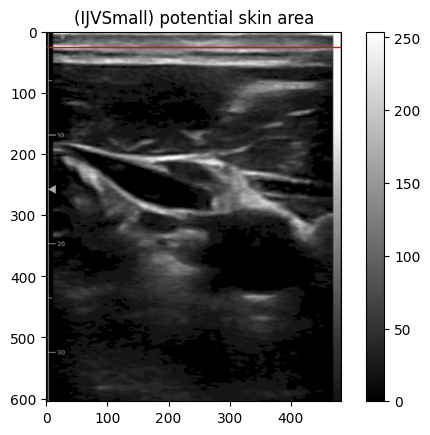

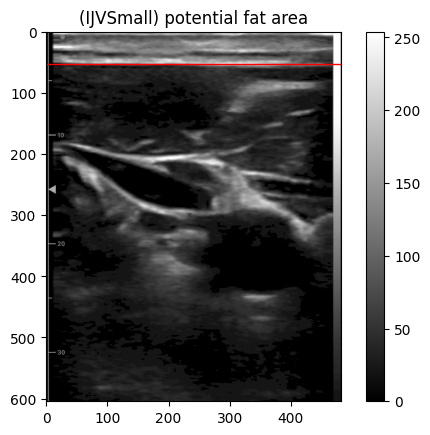

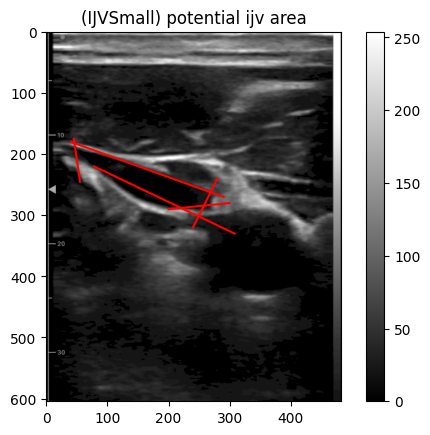

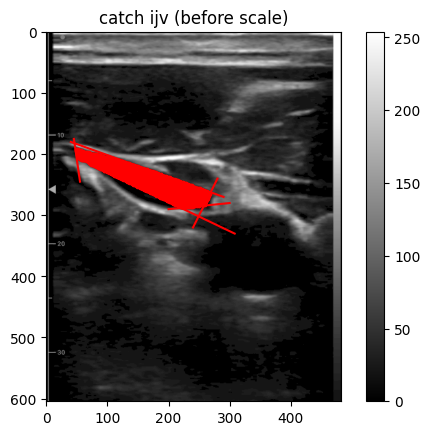

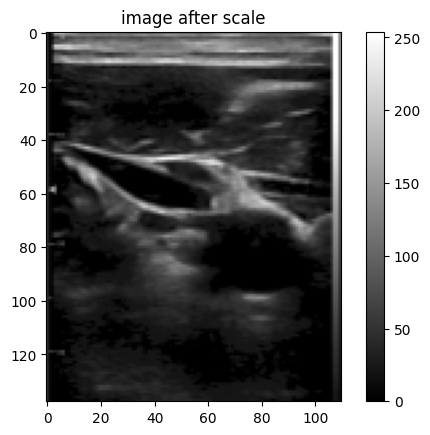

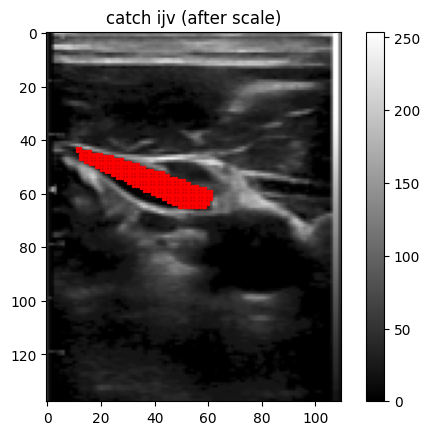

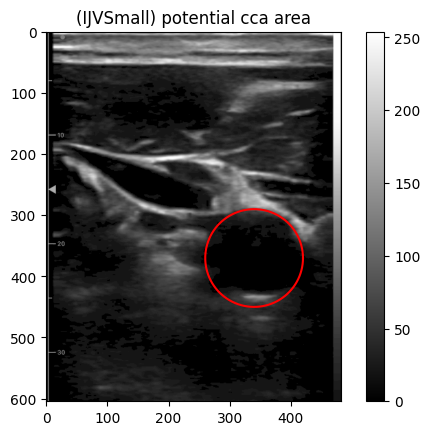

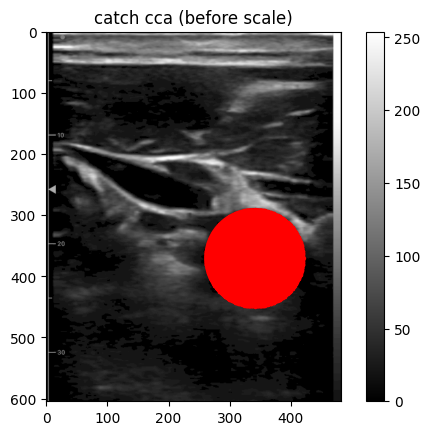

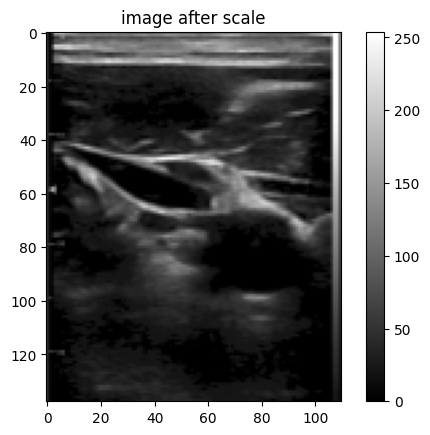

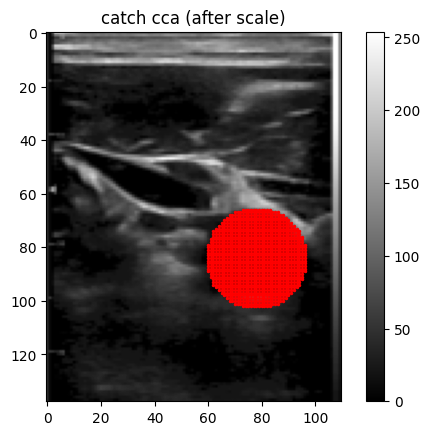

In [17]:
import numpy as np
import scipy.io as sio
import cv2
import json
import matplotlib.pyplot as plt
import os
# plt.rcParams.update({"mathtext.default": "regular"})
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["figure.dpi"] = 300

# %% parameters setting
subject = "ctchen"
os.makedirs(os.path.join("pic", subject), exist_ok=True)
date = "20220509"
state = "IJVSmall"
tissueSet = ["skin", "fat", "ijv", "cca"]
# tissueSet = ['ijv']
with open("blood_vessel_segmentation_line.json") as f:
    paramSet = json.load(f)[subject][date][state]
skinStartEdge = paramSet["skinStartEdge"]
bloodThold = paramSet["bloodThold"]
length10mmEdge = paramSet["length10mmEdge"]
voxelLength = 0.25  # [mm]
gridNumIn10mm = int(10/voxelLength)


# %% main
# plot original image
image = cv2.imread("{}_{}_{}.png".format(
    subject, date, state), cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap="gray")
plt.hlines(15, 0, 400, color="red")  # upperbound
plt.hlines(700, 0, 400, color="red")  # lowerbound
plt.plot()
plt.colorbar()
plt.title("original")
plt.savefig(os.path.join("pic", subject, "originaL_image.png"), format='png', dpi=300)
plt.show()

# plot tissue area only
plt.imshow(image[15:700], cmap="gray")
plt.colorbar()
plt.title("tissue (but no trim to skin surface)")
plt.savefig(os.path.join("pic", subject, "tissue_area_only.png"), format='png', dpi=300)
plt.show()

# trim image to start from skin surface
image = image[skinStartEdge:700]
plt.imshow(image, cmap="gray")
plt.plot([0, 0], length10mmEdge, "r.")
plt.colorbar()
plt.title("tissue (trim to skin surface)")
plt.savefig(os.path.join("pic", subject, "trim_skin_surface.png"), format='png', dpi=300)
plt.show()


# %% catch and plot real target tissue area
legalRowSet = {}
legalColSet = {}
for idx, tissue in enumerate(tissueSet):
    # highlight
    # tissue = 'ijv'
    plt.imshow(image, cmap="gray")
    # plt.plot([280,380],[420,520],'r')
    # plt.plot([60,30],[470,650],'r')
    # plt.plot([460,410],[600,400],'r')
    plt.colorbar()

    if tissue == "skin" or tissue == "fat":
        plt.axhline(y=paramSet[tissue]["x"], c="r", linewidth=1)
    if tissue == "ijv":
        for vector, edge in zip(paramSet[tissue]["v"], np.array(paramSet[tissue]["x"])):
            y = -vector[2]/vector[3]*edge - vector[1]/vector[3]
            plt.plot(y, edge, c="r")
    if tissue == "cca":
        angles = np.linspace(0, 2*np.pi, num=100)
        x = paramSet[tissue]["v"][2] * \
            np.cos(angles) + paramSet[tissue]["v"][0]
        y = paramSet[tissue]["v"][2] * \
            np.sin(angles) + paramSet[tissue]["v"][1]
        plt.plot(x, y, c="r")
    plt.title("({}) potential {} area".format(state, tissue))
    plt.show()

    if tissue == "ijv" or tissue == "cca":
        # highlight and catch target tissue
        plt.imshow(image, cmap="gray")
        plt.colorbar()
        if tissue == "ijv":
            for vector, edge in zip(paramSet[tissue]["v"], np.array(paramSet[tissue]["x"])):
                y = -vector[2]/vector[3]*edge - vector[1]/vector[3]
                plt.plot(y, edge, c="r")
        if tissue == "cca":
            angles = np.linspace(0, 2*np.pi, num=100)
            x = paramSet[tissue]["v"][2] * \
                np.cos(angles) + paramSet[tissue]["v"][0]
            y = paramSet[tissue]["v"][2] * \
                np.sin(angles) + paramSet[tissue]["v"][1] 
            plt.plot(x, y, c="r")
        # mesh coordinate
        coordinates = np.meshgrid(
            np.arange(image.shape[0]), np.flip(np.arange(image.shape[1])))
        # add dummy coordinate
        coordinates = np.insert(coordinates, 0, 1, axis=0)
        # sketch potential region
        targetMatch = np.ones((image.shape[1], image.shape[0]), dtype=bool)
        # match line
        if tissue == "ijv":
            for vector in np.array(paramSet[tissue]["v"]):
                if vector[0] == -1:
                    targetMatch = targetMatch & (
                        (vector.reshape(-1, 1, 1)[1:] * coordinates).sum(axis=0) < 0)
                if vector[0] == 1:
                    targetMatch = targetMatch & (
                        (vector.reshape(-1, 1, 1)[1:] * coordinates).sum(axis=0) > 0)
            # match blood
            targetMatch = targetMatch & (
                np.rot90(image[:image.shape[0], :image.shape[1]]) < bloodThold)
        if tissue == "cca":
            targetMatch = targetMatch & ((coordinates[1]-paramSet[tissue]["v"][1])**2 + (
                coordinates[2]-paramSet[tissue]["v"][0])**2 <= paramSet[tissue]["v"][2]**2)
        # plot image (before scale)
        legalRow, legalCol = np.where(targetMatch == True)
        legalRow = targetMatch.shape[0]-legalRow
        plt.imshow(image, cmap="gray")
        plt.plot(legalRow, legalCol, "r.", markersize=3)
        plt.title("catch {} (before scale)".format(tissue))
        plt.show()

        # plot image (after scale)
        scalePercentage = gridNumIn10mm / (length10mmEdge[1]-length10mmEdge[0])
        newImage = cv2.resize(image, (int(np.round(image.shape[1]*scalePercentage)), int(
            np.round(image.shape[0]*scalePercentage))), interpolation=cv2.INTER_AREA)
        targetMatch = targetMatch.astype(float)
        targetMatch = cv2.resize(targetMatch, (int(np.round(targetMatch.shape[1]*scalePercentage)), int(
            np.round(targetMatch.shape[0]*scalePercentage))), interpolation=cv2.INTER_AREA)
        targetMatch = targetMatch.astype(bool)
        legalRow, legalCol = np.where(targetMatch == True)
        legalRow = targetMatch.shape[0]-legalRow
        plt.imshow(newImage, cmap="gray")
        plt.colorbar()
        plt.title("image after scale")
        plt.show()
        plt.imshow(newImage, cmap="gray")
        plt.colorbar()
        plt.plot(legalRow, legalCol, "r.", markersize=3)
        plt.title("catch {} (after scale)".format(tissue))
        plt.show()

        legalRowSet[tissue] = legalRow
        legalColSet[tissue] = legalCol



In [18]:
# %% make volume
def convertUnit(length, voxelSize=voxelLength):
    numGrid = length / voxelSize
    return numGrid

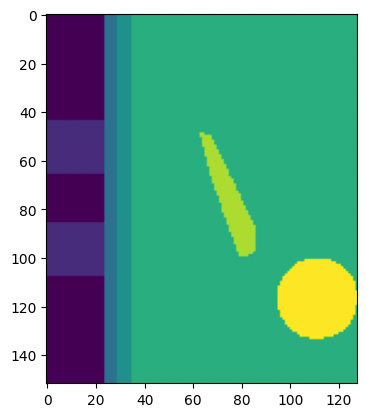

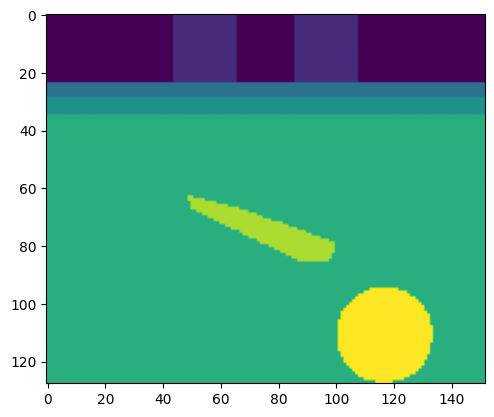

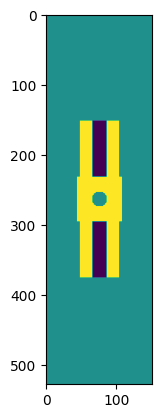

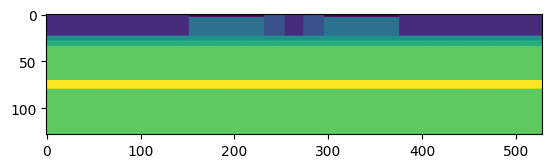

In [19]:
# related size [mm]
# model
modelX = convertUnit(132)
modelY = convertUnit(38)
modelZ = convertUnit(32)
# source
srcHolderX = convertUnit(16)
srcHolderY = convertUnit(16)
srcHolderZ = convertUnit(6)
irraWinRadius = convertUnit(2.5)
# detecotr
detHolderX = convertUnit(20)
detHolderY = convertUnit(14)
detHolderZ = convertUnit(6)
prismX = convertUnit(20)
prismY = convertUnit(5)
prismZ = convertUnit(5)
# 0.3675
fiberR = convertUnit(0.3675)

# start to construct
# model and air (in the beginning)
vol = np.ones((int(modelX), int(modelY), int(modelZ)))
# source
vol[int(modelX//2-srcHolderX//2):int(modelX//2+srcHolderX//2),
    int(modelY//2-srcHolderY//2):int(modelY//2+srcHolderY//2),
    :int(srcHolderZ)] = 2  # holder
for x in range(int(modelX//2)-int(np.ceil(irraWinRadius)), int(modelX//2)+int(np.ceil(irraWinRadius))):
    for y in range(int(modelY//2)-int(np.ceil(irraWinRadius)), int(modelY//2)+int(np.ceil(irraWinRadius))):
        isDist1 = np.sqrt((modelX//2-x)**2 + (modelY//2-y)
                          ** 2) < np.ceil(irraWinRadius)
        isDist2 = np.sqrt((modelX//2-(x+1))**2 + (modelY//2-y)
                          ** 2) < np.ceil(irraWinRadius)
        isDist3 = np.sqrt((modelX//2-x)**2 + (modelY//2-(y+1))
                          ** 2) < np.ceil(irraWinRadius)
        isDist4 = np.sqrt((modelX//2-(x+1))**2 +
                          (modelY//2-(y+1))**2) < np.ceil(irraWinRadius)
        if isDist1 or isDist2 or isDist3 or isDist4:
            vol[x][y] = 1  # air
# detector
vol[int(modelX//2+srcHolderX//2):int(modelX//2+srcHolderX//2+detHolderX),
    int(modelY//2-detHolderY//2):int(modelY//2+detHolderY//2),
    :int(detHolderZ)] = 2  # first holder
vol[int(modelX//2-srcHolderX//2-detHolderX):int(modelX//2-srcHolderX//2),
    int(modelY//2-detHolderY//2):int(modelY//2+detHolderY//2),
    :int(detHolderZ)] = 2  # second holder
vol[int(modelX//2+srcHolderX//2):int(modelX//2+srcHolderX//2+detHolderX),
    int(modelY//2-prismY//2):int(modelY//2+prismY//2),
    int(detHolderZ-prismZ):int(detHolderZ)] = 3  # first prism
vol[int(modelX//2-srcHolderX//2-detHolderX):int(modelX//2-srcHolderX//2),
    int(modelY//2-prismY//2):int(modelY//2+prismY//2),
    int(detHolderZ-prismZ):int(detHolderZ)] = 3  # second prism
vol[int(modelX//2+srcHolderX//2):int(modelX//2+srcHolderX//2+detHolderX),
    int(modelY//2-prismY//2):int(modelY//2+prismY//2),
    :int(detHolderZ-prismZ)] = 0  # first fiber
vol[int(modelX//2-srcHolderX//2-detHolderX):int(modelX//2-srcHolderX//2),
    int(modelY//2-prismY//2):int(modelY//2+prismY//2),
    :int(detHolderZ-prismZ)] = 0  # second fiber
# fiberCenterX = int(modelX//2+srcHolderX//2+detHolderX//2)
# fiberCenterY = int(modelY//2)
# for x in range(fiberCenterX-int(np.ceil(fiberR)), fiberCenterX+int(np.ceil(fiberR))):
#     for y in range(fiberCenterY-int(np.ceil(fiberR)), fiberCenterY+int(np.ceil(fiberR))):
#         isDist1 = np.sqrt((fiberCenterX-x)**2 + (fiberCenterY-y)**2) < np.ceil(fiberR)
#         isDist2 = np.sqrt((fiberCenterX-(x+1))**2 + (fiberCenterY-y)**2) < np.ceil(fiberR)
#         isDist3 = np.sqrt((fiberCenterX-x)**2 + (fiberCenterY-(y+1))**2) < np.ceil(fiberR)
#         isDist4 = np.sqrt((fiberCenterX-(x+1))**2 + (fiberCenterY-(y+1))**2) < np.ceil(fiberR)
#         if isDist1 or isDist2 or isDist3 or isDist4:
#             vol[x, y, :int(detHolderZ-prismZ)] = 0  # fiber
# muscle
vol[:, :, int(detHolderZ):] = 6
# fat
fatDepth = int(paramSet["fat"]["x"]*scalePercentage)
vol[:, :, int(detHolderZ):int(detHolderZ)+fatDepth] = 5
# skin
skinDepth = int(paramSet["skin"]["x"]*scalePercentage)
vol[:, :, int(detHolderZ):int(detHolderZ)+skinDepth] = 4
# %% Can add perturbed region
bottom_top_shift = 4
# ijv  # 7 for perturbed region
shiftNumber = np.round(modelY//2 - np.mean(legalRowSet["ijv"]), 0).astype(int)
vol[:, np.array(legalRowSet["ijv"])+shiftNumber, np.array(legalColSet["ijv"])+int(detHolderZ)-bottom_top_shift] = 7 if state == "IJVLarge" else 8
# cca
if state == "IJVSmall":
    y = np.load(f"{subject}_CCA_y.npy")
    z = np.load(f"{subject}_CCA_z.npy")
    vol[:, y, z] = 9
if state == "IJVLarge":
    vol[:, np.array(legalRowSet["cca"])+shiftNumber,
        np.array(legalColSet["cca"])+int(detHolderZ)-4-bottom_top_shift] = 9
    np.save(file=f"{subject}_CCA_y", arr=np.array(
        legalRowSet["cca"])+shiftNumber)
    np.save(file=f"{subject}_CCA_z", arr=np.array(
        legalColSet["cca"])+int(detHolderZ)-4)

if state == 'IJVSmall':
    # # add change muscle 10%
    # muscle_shift = 10
    # vol[:, np.array(legalRowSet["ijv"])+shiftNumber+muscle_shift, np.array(legalColSet["ijv"])+int(detHolderZ)+muscle_shift] = 10
    # vol[:, np.array(legalRowSet["ijv"])+shiftNumber+muscle_shift, np.array(legalColSet["ijv"])+int(detHolderZ)-muscle_shift] = 10
    # vol[:, np.array(legalRowSet["ijv"])+shiftNumber-muscle_shift, np.array(legalColSet["ijv"])+int(detHolderZ)+muscle_shift] = 10
    # vol[:, np.array(legalRowSet["ijv"])+shiftNumber-muscle_shift, np.array(legalColSet["ijv"])+int(detHolderZ)-muscle_shift] = 10

    # # add change muscle 5%
    # muscle_shift = 5
    # vol[:, np.array(legalRowSet["ijv"])+shiftNumber+muscle_shift, np.array(legalColSet["ijv"])+int(detHolderZ)+muscle_shift] = 11
    # vol[:, np.array(legalRowSet["ijv"])+shiftNumber+muscle_shift, np.array(legalColSet["ijv"])+int(detHolderZ)-muscle_shift] = 11
    # vol[:, np.array(legalRowSet["ijv"])+shiftNumber-muscle_shift, np.array(legalColSet["ijv"])+int(detHolderZ)+muscle_shift] = 11
    # vol[:, np.array(legalRowSet["ijv"])+shiftNumber-muscle_shift, np.array(legalColSet["ijv"])+int(detHolderZ)-muscle_shift] = 11

    # # add change muscle 3%
    # muscle_shift = 3
    # vol[:, np.array(legalRowSet["ijv"])+shiftNumber+muscle_shift, np.array(legalColSet["ijv"])+int(detHolderZ)+muscle_shift] = 12
    # vol[:, np.array(legalRowSet["ijv"])+shiftNumber+muscle_shift, np.array(legalColSet["ijv"])+int(detHolderZ)-muscle_shift] = 12
    # vol[:, np.array(legalRowSet["ijv"])+shiftNumber-muscle_shift, np.array(legalColSet["ijv"])+int(detHolderZ)+muscle_shift] = 12
    # vol[:, np.array(legalRowSet["ijv"])+shiftNumber-muscle_shift, np.array(legalColSet["ijv"])+int(detHolderZ)-muscle_shift] = 12

    # change IJV_Small +1%
    bottom_top_shift = 7
    # left_right_shift = 40
    # vol[:, np.array(legalRowSet["ijv"])+shiftNumber+left_right_shift, np.array(legalColSet["ijv"])+int(detHolderZ)] = 13 #right
    # vol[:, np.array(legalRowSet["ijv"])+shiftNumber-left_right_shift, np.array(legalColSet["ijv"])+int(detHolderZ)] = 13 #left
    # vol[:, np.array(legalRowSet["ijv"])+shiftNumber, np.array(legalColSet["ijv"])+int(detHolderZ)+bottom_top_shift] = 13 # bottom
    # vol[:, np.array(legalRowSet["ijv"])+shiftNumber, np.array(legalColSet["ijv"])+int(detHolderZ)-bottom_top_shift] = 13 # top

# ijv  # 7 for perturbed region --> make sure ijv not be replace
# shiftNumber = np.round(modelY//2 - np.mean(legalRowSet["ijv"]), 0).astype(int)
# vol[:, np.array(legalRowSet["ijv"])+shiftNumber, np.array(legalColSet["ijv"])+int(detHolderZ)] = 7 if state == "IJVLarge" else 8
# cca
# if state == "IJVSmall":
#     y = np.load(f"{subject}_CCA_y.npy")
#     z = np.load(f"{subject}_CCA_z.npy")
#     vol[:, y, z] = 9
# if state == "IJVLarge":
#     vol[:, np.array(legalRowSet["cca"])+shiftNumber,
#         np.array(legalColSet["cca"])+int(detHolderZ)-4] = 9
#     np.save(file=f"{subject}_CCA_y", arr=np.array(
#         legalRowSet["cca"])+shiftNumber)
#     np.save(file=f"{subject}_CCA_z", arr=np.array(
#         legalColSet["cca"])+int(detHolderZ)-4)


# vol[:, 78, 62] = 7  # fill the hole
plt.imshow(vol[int(modelX//2), :, :])
plt.show()
plt.imshow(vol[int(modelX//2), :, :].T)
plt.savefig(os.path.join("pic", subject, "horizontal_view.png"), format='png', dpi=300)
plt.show()
plt.imshow(vol[:, :, 0])
plt.savefig(os.path.join("pic", subject, "sagittal_view.png"), format='png', dpi=300)
plt.show()
plt.imshow(vol[:, int(modelY//2), :].T)
plt.savefig(os.path.join("pic", subject, "coronal_view.png"), format='png', dpi=300)
plt.show()
# save file
vol = vol.astype(np.uint8)

if state == 'IJVSmall':
    np.save(file=f"{subject}_perturbed_small", arr=vol)
else:
    np.save(file=f"{subject}_perturbed_large", arr=vol)



In [20]:
# get perturbed vol
# small = np.load(f"{subject}_perturbed_small.npy")
# large = np.load(f"{subject}_perturbed_large.npy")
# exclusive_large_ijv = np.where((large == 7) & (small == 6)) # Large_IJV exclusive small_IJV (or you can call perturbed region)
# exclusive_small_ijv = np.where((small == 8))
# small_vol = np.copy(small)
# for i in range(0, len(exclusive_large_ijv[0])):
#     small_vol[exclusive_large_ijv[0][i], exclusive_large_ijv[1][i], exclusive_large_ijv[2][i]] = 7
# plt.imshow(small_vol[int(528//2), :, :].T)
# plt.show()
# np.save(file=f"{subject}_perturbed_small_to_large", arr=small_vol)

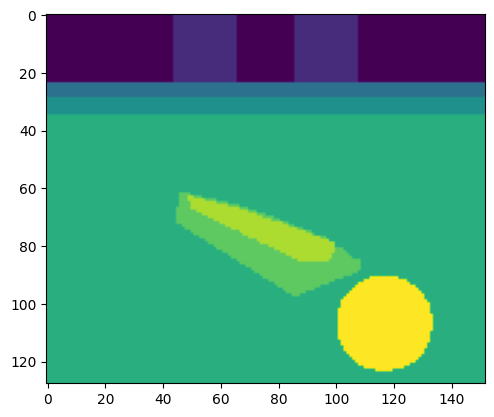

In [21]:
# get perturbed vol
small = np.load(f"{subject}_perturbed_small.npy")
large = np.load(f"{subject}_perturbed_large.npy")
exclusive_large_ijv = np.where((large == 7) & (small == 6)) # Large_IJV exclusive small_IJV (or you can call perturbed region)
exclusive_small_ijv = np.where((small == 8))
large_vol = np.copy(large)
for i in range(0, len(exclusive_small_ijv[0])):
    large_vol[exclusive_small_ijv[0][i], exclusive_small_ijv[1][i], exclusive_small_ijv[2][i]] = 8
plt.imshow(large_vol[int(528//2), :, :].T)
plt.savefig(os.path.join("pic", subject, "horizontal_merge_view.png"), format='png', dpi=300)
plt.show()
np.save(file=f"{subject}_perturbed_small_to_large", arr=large_vol)

In [22]:
large_vol.shape

(528, 152, 128)

In [23]:
np.where(large_vol==8,1,0).sum()/274032

0.8034682080924855

In [24]:
(np.where(large_vol==7,1,0).sum()+np.where(large_vol==8,1,0).sum())/731808

0.7943722943722944